In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from scipy.ndimage import median_filter
import sys
import os
import struct
import pywt

sys.path.append(os.path.join(os.getcwd(), 'EC'))
import constants
import Func_read_data
import Func_despike_data
import sensor_info
import Func_DR
import Func_MRFD

importlib.reload(Func_read_data)
importlib.reload(Func_despike_data)
importlib.reload(constants)
importlib.reload(sensor_info)
importlib.reload(Func_DR)
importlib.reload(Func_MRFD)

from Func_read_data import *
from constants import *
from Func_despike_data import *
from sensor_info import *
from Func_MRFD import *
from Func_DR import *

In [ ]:
"""TO DO
- process 16 and 26 m data fast 2024
- run Eddypro all heights
- choose events of BS and no BS
- plot events slowdata and fluxes in heights
- make MO script  
- SPC processing scripts
"""

In [48]:
folder='/run/user/72637/gvfs/smb-share:server=memobi.wsl.ch,share=pub/Turbulence/PEA/Season_2024-2025/DATA/MET/converted/'
folder='/home/engbers/Documents/PhD/EC_data_convert/converted/'
sensor='CSAT'
start='2024-01-01 00:00'
end='2025-03-01 00:00'

"""GET SENSOR INFO"""
plim, calibration_coefficients, heights = get_sensor_info(sensor, 2024)

"""READ FAST AND SLOW DATA from folder"""

# fastdata=read_data(folder, 'fast', sensor, start, end)
file_numbers_array = [i for i in range(10, 11, 1)]
for file_number in file_numbers_array:
    file_numbers = np.arange(file_number, file_number + 2).astype(int).astype(str)
    print(file_numbers)
    fastdata=read_data(folder, 'fast', sensor, start, end, file_numbers=file_numbers)

    fastdata_CSAT16 = pd.DataFrame()
    fastdata_CSAT26 = pd.DataFrame()

    # Assign columns and copy attributes
    fastdata_CSAT16[['Ux', 'Uy', 'Uz', 'Ts', 'diag_csat']] = fastdata[['Ux1', 'Uy1', 'Uz1', 'Ts1', 'diag_csat1']]
    fastdata_CSAT26[['Ux', 'Uy', 'Uz', 'Ts', 'diag_csat']] = fastdata[['Ux2', 'Uy2', 'Uz2', 'Ts2', 'diag_csat2']]

    # Assign attributes (units) to each column
    fastdata_CSAT16.attrs['units'] = {'Ux': 'm/s', 'Uy': 'm/s', 'Uz': 'm/s', 'Ts': 'degC', 'diag_csat': 'none'}
    fastdata_CSAT26.attrs['units'] = {'Ux': 'm/s', 'Uy': 'm/s', 'Uz': 'm/s', 'Ts': 'degC', 'diag_csat': 'none'}
    # """DESPIKE FASTDATA"""
    # despiked_fastdata_CSAT16=despike_fast_MAD(fastdata_CSAT16, None, plim, 'CSAT16', plot_despike=False)
    # """SAVE DESPIKED DATA"""
    # output_folder=f'/home/engbers/Documents/PhD/EC_data_convert/CSAT_16m/20240{file_number}'
    # save_despiked_data(fastdata_CSAT16, despiked_fastdata_CSAT16, output_folder, sensor)
    # """DESPIKE FASTDATA"""
    # despiked_fastdata_CSAT26=despike_fast_MAD(fastdata_CSAT26, None, plim, 'CSAT26', plot_despike=False)
    # """SAVE DESPIKED DATA"""
    # output_folder=f'/home/engbers/Documents/PhD/EC_data_convert/CSAT_26m/20240{file_number}'
    # save_despiked_data(fastdata_CSAT26, despiked_fastdata_CSAT26, output_folder, sensor)

None
['10' '11']
TOA5_1153.PEAFAST10.dat
reading data TOA5_1153.PEAFAST10.dat
TOA5_1153.PEAFAST11.dat
reading data TOA5_1153.PEAFAST11.dat
Heights dictionary: {}
Unique dates in the DataFrame: ['2024-10-12', '2024-10-13', '2024-10-14', '2024-10-15', '2024-10-16', '2024-10-17', '2024-10-18', '2024-10-19', '2024-10-20', '2024-10-21', '2024-10-22', '2024-10-23', '2024-10-24', '2024-10-25', '2024-10-26', '2024-10-27', '2024-10-28', '2024-10-29', '2024-10-30', '2024-10-31', '2024-11-01', '2024-11-02', '2024-11-03', '2024-11-04', '2024-11-05', '2024-11-06', '2024-11-07', '2024-11-08', '2024-11-09', '2024-11-10', '2024-11-11', '2024-11-12', '2024-11-13', '2024-11-14', '2024-11-15', '2024-11-16', '2024-11-17', '2024-11-18', '2024-11-19', '2024-11-20', '2024-11-21', '2024-11-22', '2024-11-23', '2024-11-24', '2024-11-25']


In [49]:
fastdata_CSAT16

,Ux,Uy,Uz,Ts,diag_csat
TIMESTAMP,,,,,
2024-10-12 11:51:46.500,-2.44225,-5.14950,0.29425,-18.81148,0
2024-10-12 11:51:46.600,-2.35275,-5.21050,0.45650,-18.88785,0
2024-10-12 11:51:46.700,-2.36300,-5.34750,0.37050,-18.72237,0
2024-10-12 11:51:46.800,-2.54700,-5.43000,0.22650,-18.53935,0
2024-10-12 11:51:46.900,-2.33600,-5.40575,0.14600,-18.56641,0
...,...,...,...,...,...
2024-11-25 17:36:11.200,-1.47200,0.69050,-0.16950,-11.35577,0
2024-11-25 17:36:11.300,-1.48150,0.68875,-0.18400,-11.37839,0
2024-11-25 17:36:11.400,-1.49750,0.69225,-0.17825,-11.41391,0


In [67]:
""" DOUBLE ROTATE ALL FILES IN PRE EDDYPRO FORMAT"""

def process_2024_folders(base_directory):
    # List all folders starting with "2024"
    for folder in os.listdir(base_directory):
        if folder.startswith("2024"):
            folder_path = os.path.join(base_directory, folder)
            # Read all .dat files in the folder
            dat_files = read_dat_files(folder_path)
            for dat_file in dat_files:
                print(f"Processing file: {dat_file}")
                # Read the DataFrame
                df=read_dat_file(dat_file)
                # df = pd.read_csv(dat_file, sep='\t', header=0, skiprows=1, index_col=0)
                # Apply double rotation
                rotated_df, angles = double_rotation(df)
                # Save the modified DataFrame
                save_dat_file(rotated_df, dat_file)
def read_dat_files(folder_path):
    """List all .dat files in the given folder."""
    return [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.dat')]

def list_2024_folders(base_directory):
    """List all folders starting with '2024' in the given directory."""
    return [folder for folder in os.listdir(base_directory) if folder.startswith('2024') and os.path.isdir(os.path.join(base_directory, folder))]

def read_dat_file(file_path):
    """Read a tab-separated .dat file, using the first row as header and discarding the second row."""
    from datetime import datetime
    # Define a custom date parser to handle both formats
    def custom_date_parser(date_str):
        for fmt in ('%Y-%m-%d %H:%M:%S.%f', '%Y-%m-%d %H:%M:%S'):
            try:
                return datetime.strptime(date_str, fmt)
            except ValueError:
                continue
        return pd.NaT  # Return NaT if no format matches
    # Read the file and parse the first column as datetime
    df = pd.read_csv(file_path, sep='\t', header=0, parse_dates=[0], date_parser=custom_date_parser)
    # Drop the second row (index 0 after header)
    df = df.drop(index=0)
    # Set the first column as the index
    df.set_index(df.columns[0], inplace=True)
    # Convert other columns to float64
    df = df.astype('float64', errors='ignore')
    return df

def read_dat_file(file_path):
    """Read a tab-separated .dat file, using the first row as header and discarding the second row."""
    # Read the file without parsing dates
    df = pd.read_csv(file_path, sep='\t', header=0)

    # Convert the first column to datetime using multiple formats
    df[df.columns[0]] = pd.to_datetime(
        df[df.columns[0]],
        format=None,  # Let pandas infer the format
        errors='coerce'  # Handle invalid formats gracefully
    )

    # Drop the second row (index 0 after header)
    df = df.drop(index=0)

    # Set the first column as the index
    df.set_index(df.columns[0], inplace=True)

    # Convert other columns to float64
    df = df.astype('float64', errors='ignore')

    return df
def save_dat_file(df, file_path):
    """Save the DataFrame to a tab-separated .dat file."""
    df.to_csv(file_path, sep='\t', header=True)  # Save with the same name and format

def process_data(file_path):
    import pandas as pd

    # Read the .dat file, using the first row as header and skipping the second row
    df = pd.read_csv(file_path, sep='\t', header=0, skiprows=[1])
    
    # Set the first column as the index
    df.set_index(df.columns[0], inplace=True)
    
    # Apply the double_rotation function
    df_rotated = double_rotation(df)
    
    # Save the modified DataFrame back to a .dat file
    df_rotated.to_csv(file_path, sep='\t')

path='/home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/'
df=process_2024_folders(path)

Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-20_1600.dat
Double rotation for blocks of 0 days 00:30:00
Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-29_2000.dat
Double rotation for blocks of 0 days 00:30:00
Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-27_0500.dat
Double rotation for blocks of 0 days 00:30:00
Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-22_1600.dat
Double rotation for blocks of 0 days 00:30:00
Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-27_2100.dat
Double rotation for blocks of 0 days 00:30:00
Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-29_1700.dat
Double rotation for blocks of 0 days 00:30:0

/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-28_1900.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-19_1700.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-20_1200.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-26_0000.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-29_0500.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-18_2300.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-18_1700.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-21_0500.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-23_0200.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-24_0600.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-20_0200.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-22_0100.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-23_0900.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-24_0300.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-19_0100.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-19_1200.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-25_1700.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-20_0300.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-23_0500.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-28_0200.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-21_1900.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-21_0100.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-23_2200.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-28_1100.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-22_0300.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-23_2000.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-26_0600.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-24_0700.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-21_1700.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-20_0000.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-26_0300.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-21_2000.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-28_0700.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-25_1000.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-18_1900.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-24_1500.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-17_2200.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-21_1800.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-25_2100.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-29_0600.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-18_0900.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-25_2300.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


Processing file: /home/engbers/Documents/PhD/EC_data_convert/CSAT_26m_Copy/202402/CSAT_Fastdata_proc_2024-02-25_1500.dat
Double rotation for blocks of 0 days 00:30:00


/tmp/ipykernel_51978/1641200359.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[df.columns[0]] = pd.to_datetime(


KeyboardInterrupt: 

In [54]:
# double_rotation(df)
# np.arctan2(np.nanmean(df[:, 1]), np.nanmean(df[:, 0]))
df

(                                Ux        Uy        Uz        Ts
 Unnamed: 0                                                      
 2024-05-14 08:00:00.000  24.959159 -0.714440  1.262225 -21.02782
 2024-05-14 08:00:00.100  23.493648 -1.495412  0.222639 -21.28915
 2024-05-14 08:00:00.200  25.801517  3.093961 -0.354181 -23.09094
 2024-05-14 08:00:00.300  24.714199 -2.800656 -0.905657 -20.78381
 2024-05-14 08:00:00.400  21.900992 -1.521464 -1.571893 -21.91103
 ...                            ...       ...       ...       ...
 2024-05-14 08:59:59.500  25.350665  1.874115 -0.288046 -20.00026
 2024-05-14 08:59:59.600  26.741690  1.947059 -0.548938 -20.76321
 2024-05-14 08:59:59.700  25.208037  2.073086 -0.489459 -20.25259
 2024-05-14 08:59:59.800  24.557268  2.498952 -0.191623 -20.83769
 2024-05-14 08:59:59.900  24.707773  1.627701  0.041264 -21.11653
 
 [36000 rows x 4 columns],
                        theta       phi
 2024-05-14 08:00:00 -2.29917 -0.026928)

In [46]:
df['Ux'].values

array(['-17.164', '-16.753', '-14.8535', ..., '-15.218', '-14.4725',
       '-15.227'], dtype=object)

In [3]:
"""DOUBLE ROTATE THE DATA TO ALIGN WIND VECTOR WITH X-AXIS"""
fastdata_rot, angles=double_rotation(despiked_fastdata_CSAT26)


Double rotation for blocks of 0 days 00:30:00


/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_DR.py:53: RuntimeWarning: Mean of empty slice
  theta = np.arctan2(np.nanmean(wind_unrot[:, 1]), np.nanmean(wind_unrot[:, 0]))
/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_DR.py:59: RuntimeWarning: Mean of empty slice
  phi = np.arctan2(np.nanmean(wind1[:, 2]), np.nanmean(wind1[:, 0]))
/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_DR.py:53: RuntimeWarning: Mean of empty slice
  theta = np.arctan2(np.nanmean(wind_unrot[:, 1]), np.nanmean(wind_unrot[:, 0]))
/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_DR.py:59: RuntimeWarning: Mean of empty slice
  phi = np.arctan2(np.nanmean(wind1[:, 2]), np.nanmean(wind1[:, 0]))
/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_DR.py:53: RuntimeWarning: Mean of empty slice
  theta = np.arctan2(np.nanmean(wind_unrot[:, 1]), np.nanmean(wind_unrot[:, 0]))
/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_DR.py:59: RuntimeWarnin

/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_MRFD.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gaps = pd.concat([gaps, pd.DataFrame({'idx_before_gap': [len(data)],


MRD for DataFrame
Number of gaps: 1


  0%|          | 0/1000000 [00:00<?, ?it/s]/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_MRFD.py:43: RuntimeWarning: Mean of empty slice
  wmeans_a[i] = np.nanmean(data_a2[k:k+l]) #changed mean to nanmean
/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_MRFD.py:44: RuntimeWarning: Mean of empty slice
  wmeans_b[i] = np.nanmean(data_b2[k:k+l]) #changed mean to nanmean
/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_MRFD.py:49: RuntimeWarning: Mean of empty slice
  D[ms] = np.nanmean(wmeans_a * wmeans_b) #changed mean to nanmean
/home/engbers/miniconda3/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 88%|████████▊ | 878169/1000000 [16:03<02:13, 911.65it/s] 


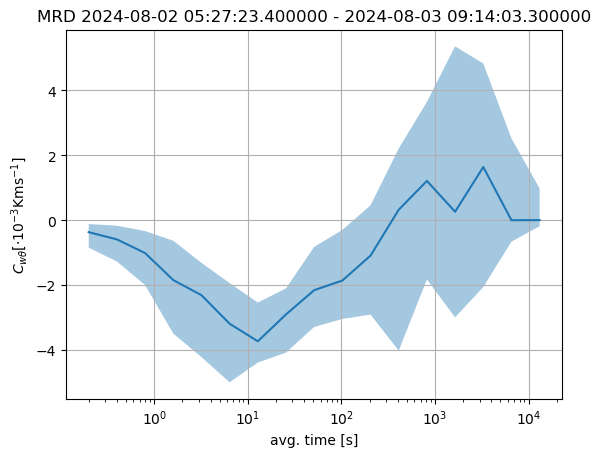

In [19]:
#### 26m tower 
fastdata_rot['time']=fastdata_rot.index
fastdata_rot
M=17
(mrd_x, mrd_data, time_middle)=completemrd(fastdata_rot[1000000:2000000], 'Uz', 'Ts', M, shift=round(int(0.1 * 2**M)), plot=True)

/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_MRFD.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gaps = pd.concat([gaps, pd.DataFrame({'idx_before_gap': [len(data)],


MRD for DataFrame
Number of gaps: 1


 88%|████████▊ | 878169/1000000 [10:31<01:27, 1391.06it/s]


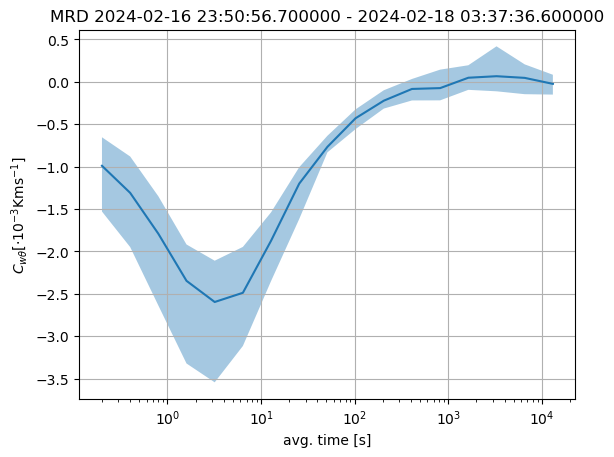

In [ ]:
#### 16m tower
M=17
(mrd_x, mrd_data, time_middle)=completemrd(fastdata_rot[0:1000000], 'Uz', 'Ts', M, shift=round(int(0.1 * 2**M)), plot=True)

/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_MRFD.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gaps = pd.concat([gaps, pd.DataFrame({'idx_before_gap': [len(data)],


MRD for DataFrame
Number of gaps: 1


 88%|████████▊ | 878169/1000000 [06:47<00:56, 2153.35it/s]


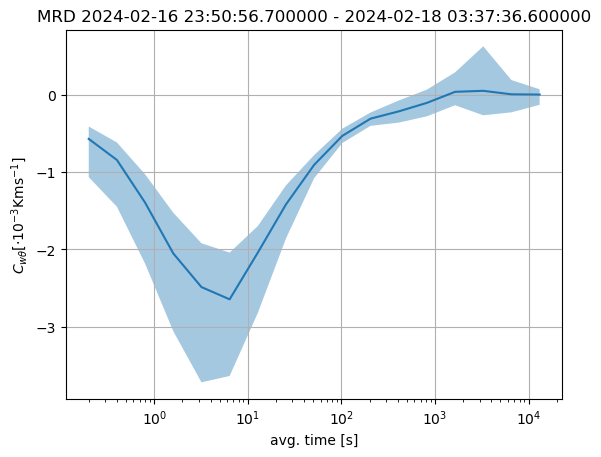

In [7]:
#### 26m tower
M=17
(mrd_x, mrd_data, time_middle)=completemrd(fastdata_rot[0:1000000], 'Uz', 'Ts', M, shift=round(int(0.1 * 2**M)), plot=True)

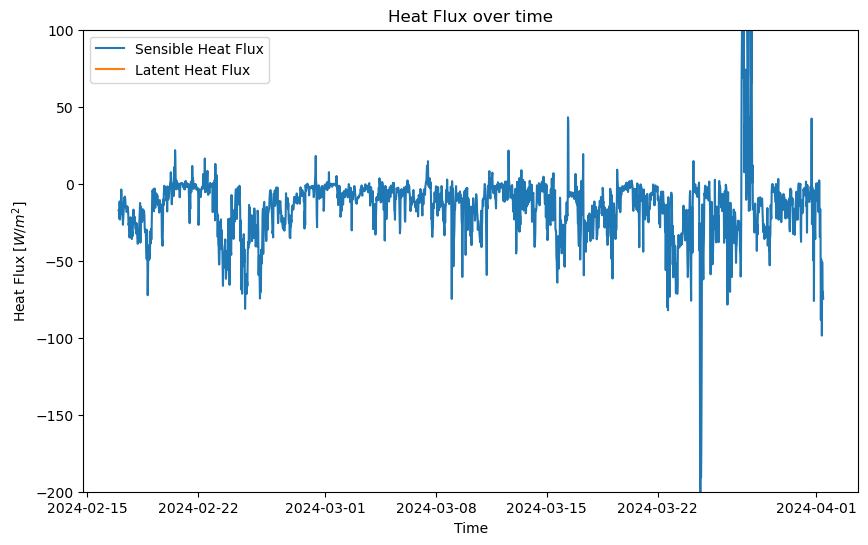

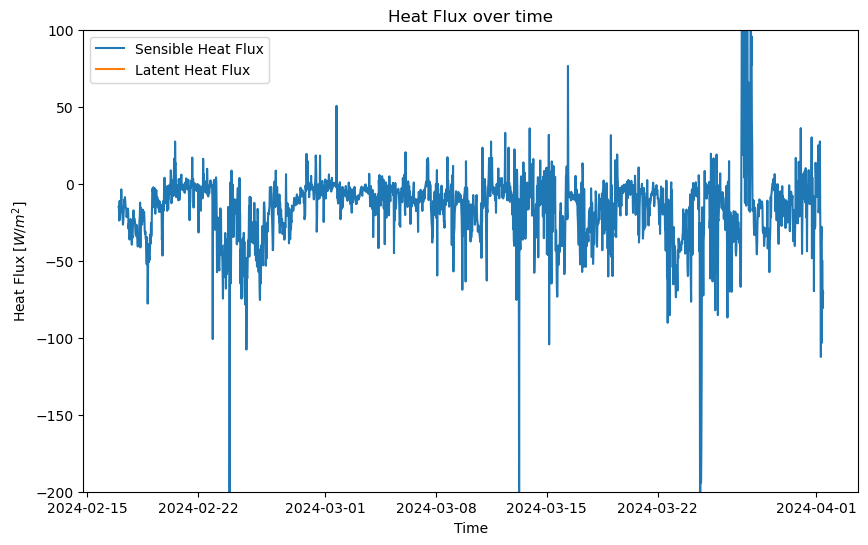

In [12]:
""" CHECK HEATFLUX QUICKLY WITH AVERAGING INTERVAL FOM MRD"""
df_heatflux=check_heat_flux(fastdata_rot, '1min', plot=True)
df_heatflux=check_heat_flux(fastdata_rot, '10min', plot=True)

In [3]:
folder='/run/user/72637/gvfs/smb-share:server=memobi.wsl.ch,share=pub/Turbulence/PEA/Season_2024-2025/DATA/MET/converted/'
folder='/home/engbers/Documents/PhD/EC_data_convert/converted/'
sensor='SFC'
start='2024-01-01 00:00'
end='2025-03-01 00:00'

"""GET SENSOR INFO"""
plim, calibration_coefficients, heights = get_sensor_info(sensor, 2024)

"""READ FAST AND SLOW DATA from folder"""
slowdata=read_data(folder, 'slow', sensor, start, end, plot_data=False)

#start_file=496
file_numbers_array = [i for i in range(489, 500, 6)]
for file_number in file_numbers_array:
    file_numbers = np.arange(file_number, file_number + 7).astype(int).astype(str)
    print(file_numbers)
    fastdata_SFC=read_data(folder, 'fast', sensor, start, end, file_numbers=file_numbers)

    """DESPIKE AND PLOT FASTDATA"""
    despiked_fastdata=despike_fast_MAD(fastdata_SFC, slowdata, plim, sensor, calibration_coefficients=calibration_coefficients, plot_despike=True)

    """SAVE DESPIKED DATA"""
    output_folder='/home/engbers/Documents/PhD/EC_data_convert/SFC/202402'
    save_despiked_data(fastdata_SFC, despiked_fastdata, output_folder, sensor)


Using 2024 calibration coefficients
{'A': 4820.04, 'B': 3792900.0, 'C': -115477000.0, 'H2O_Zero': 0.7087, 'H20_Span': 0.9885}
['489' '490' '491' '492' '493' '494' '495']
Heights dictionary: {}
Unique dates in the DataFrame: ['2024-03-16', '2024-03-17', '2024-03-18', '2024-03-19', '2024-03-20', '2024-03-21', '2024-03-22', '2024-03-23']
Plausibility limits: Discarding 28 'u' records.
Plausibility limits: Discarding 6 'v' records.
Plausibility limits: Discarding 51 'w' records.
Plausibility limits: Discarding 13 'Ts' records.
Plausibility limits: Discarding 2 'H2O' records.
diag_csat: Discarding 39507 'CSAT' records.
Plausibility limits applied
Applying H2O calibration
Mean H2O concentration difference: 103.19796940646242
H2O calibration applied
Processing large dataset (%)
Spikes removed from Ux,Uy,Uz,Ts:5552 Spikes removed from LI_H2Om_corr:6187
Plotting despiking results


/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_despike_data.py:223: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'/home/engbers/Documents/PhD/EC_data_convert/SFC/plots_despiking/EC_despiked_{sensor}_{fastdata.index[0].strftime('%Y%m%d')}.png', bbox_inches='tight')
/home/engbers/Documents/Github/DataProcessingScripts/Func_read_data.py:388: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  for date, group in save_fastdata.groupby(pd.Grouper(freq='H')):


25800
Processing date: 2024-03-16 08:00:00
36000
Processing date: 2024-03-16 09:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/SFC/202402/SFC_Fastdata_proc_2024-03-16_0900.dat
36000
Processing date: 2024-03-16 10:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/SFC/202402/SFC_Fastdata_proc_2024-03-16_1000.dat
36000
Processing date: 2024-03-16 11:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/SFC/202402/SFC_Fastdata_proc_2024-03-16_1100.dat
36000
Processing date: 2024-03-16 12:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/SFC/202402/SFC_Fastdata_proc_2024-03-16_1200.dat
36000
Processing date: 2024-03-16 13:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/SFC/202402/SFC_Fastdata_proc_2024-03-16_1300.dat
36000
Processing date: 2024-03-16 14:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/SFC/202402/SFC_Fastdata_proc_2024-03-16_1400.dat
360

/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_despike_data.py:223: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'/home/engbers/Documents/PhD/EC_data_convert/SFC/plots_despiking/EC_despiked_{sensor}_{fastdata.index[0].strftime('%Y%m%d')}.png', bbox_inches='tight')
/home/engbers/Documents/Github/DataProcessingScripts/Func_read_data.py:388: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  for date, group in save_fastdata.groupby(pd.Grouper(freq='H')):


25800
Processing date: 2024-03-22 08:00:00
36000
Processing date: 2024-03-22 09:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/SFC/202402/SFC_Fastdata_proc_2024-03-22_0900.dat
36000
Processing date: 2024-03-22 10:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/SFC/202402/SFC_Fastdata_proc_2024-03-22_1000.dat
36000
Processing date: 2024-03-22 11:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/SFC/202402/SFC_Fastdata_proc_2024-03-22_1100.dat
36000
Processing date: 2024-03-22 12:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/SFC/202402/SFC_Fastdata_proc_2024-03-22_1200.dat
36000
Processing date: 2024-03-22 13:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/SFC/202402/SFC_Fastdata_proc_2024-03-22_1300.dat
36000
Processing date: 2024-03-22 14:00:00
Data saved per hour in /home/engbers/Documents/PhD/EC_data_convert/SFC/202402/SFC_Fastdata_proc_2024-03-22_1400.dat
360

/home/engbers/Documents/Github/DataProcessingScripts/Func_read_data.py:269: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'./plots/{sensor}_{start}_slowdata.png')


(<Figure size 1300x1400 with 7 Axes>,
 array([<Axes: ylabel='Temperature [oC]'>, <Axes: ylabel='RH wrt ice [%]'>,
        <Axes: ylabel='Wind Direction'>, <Axes: ylabel='Wind Speed[ms-1]'>,
        <Axes: ylabel='Net Radiation [Wm-2]'>,
        <Axes: ylabel='Net Radiation [Wm-2]'>,
        <Axes: ylabel='Flowcapt [g/m2/s]'>], dtype=object))

/home/engbers/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


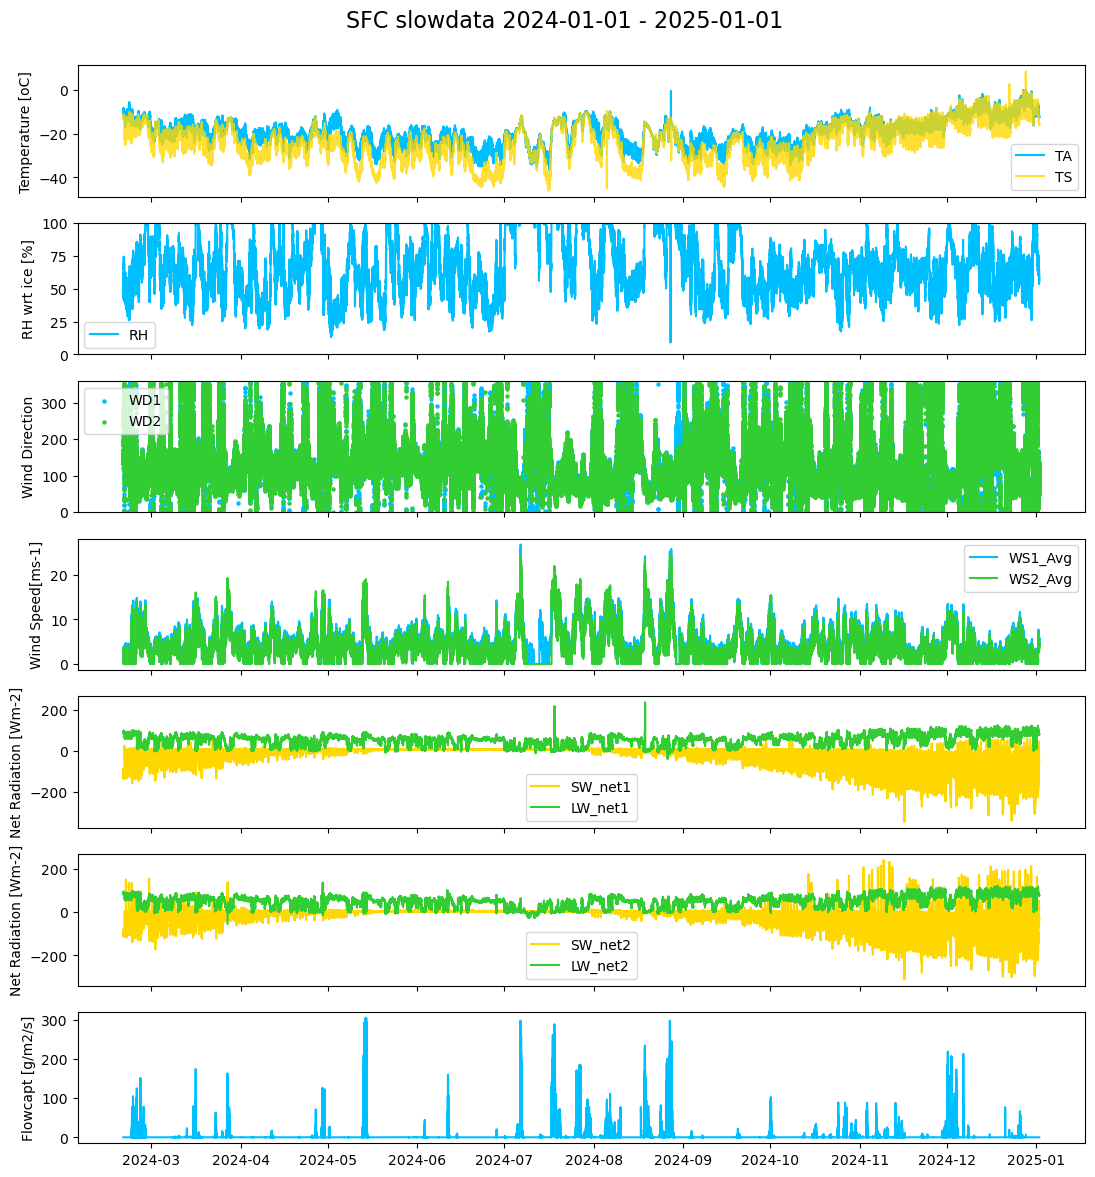

In [ ]:
plot_SFC_slowdata(slowdata_cleaned, sensor, start, end)

Plausibility limits: Discarding 2 'u' records.
Plausibility limits: Discarding 2 'v' records.
Plausibility limits: Discarding 3 'w' records.
diag_csat: Discarding 2173 'CSAT' records.
Plausibility limits applied
Applying H2O calibration
Mean H2O concentration difference: 105.16096456888627
H2O calibration applied
Processing large dataset (%)
Spikes removed from Ux,Uy,Uz,Ts:1775 Spikes removed from LI_H2Om_corr:2264


/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_despike_data.py:221: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'/home/engbers/Documents/PhD/Data/EC_despiked/Figures/EC_despiked_{sensor}.png', bbox_inches='tight')
/home/engbers/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


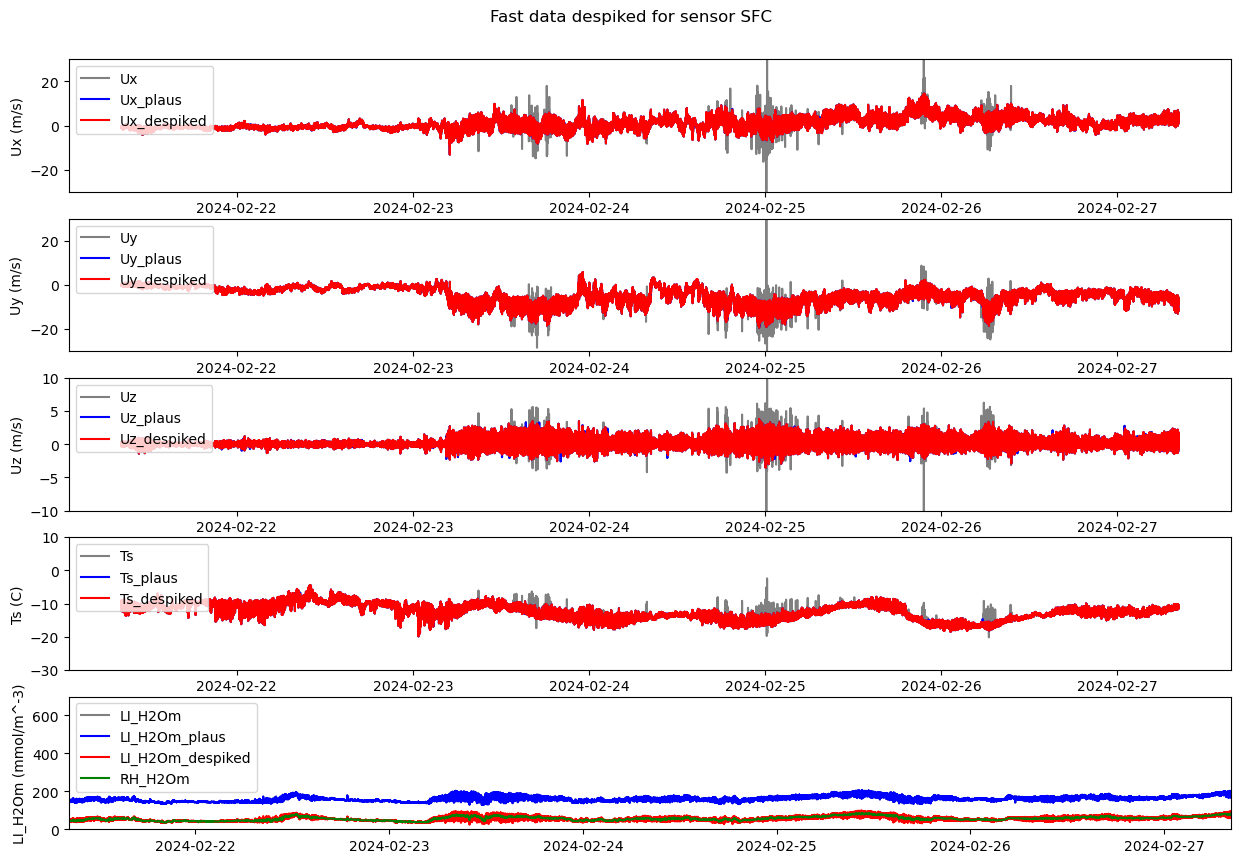

'DOUBLE ROTATE THE DATA TO ALIGN WIND VECTOR WITH X-AXIS'

In [3]:
"""DESPIKE AND PLOT FASTDATA"""
despiked_fastdata=despike_fast_MAD(fastdata_SFC, slowdata, plim, sensor, calibration_coefficients=calibration_coefficients, plot_despike=True)
# despiked_fastdata=despike_fast_MAD(fastdata_SFC, slowdata, plim, sensor, plot_despike=True)

"""DOUBLE ROTATE THE DATA TO ALIGN WIND VECTOR WITH X-AXIS"""
# fastdata_rot, angles=double_rotation(despiked_fastdata)


# """ APPLY MRD TO FIND AVERAGING  TIMESCALE"""

# M=16
# (mrd_x, mrd_data, time_middle)=completemrd(fastdata_rot, 'Uz', 'Ts', M, shift=round(int(0.1 * 2**M)), plot=True)

In [5]:
"""DOUBLE ROTATE THE DATA TO ALIGN WIND VECTOR WITH X-AXIS"""
fastdata_rot, angles=double_rotation(despiked_fastdata)


# """ APPLY MRD TO FIND AVERAGING  TIMESCALE"""

# M=17
# (mrd_x, mrd_data, time_middle)=completemrd(fastdata_rot, 'Uz', 'Ts', M, shift=round(int(0.1 * 2**M)), plot=True)

Double rotation for blocks of 0 days 00:30:00


/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_MRFD.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gaps = pd.concat([gaps, pd.DataFrame({'idx_before_gap': [len(data)],


MRD for DataFrame
Number of gaps: 1


  0%|          | 0/1000000 [00:00<?, ?it/s]

/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_MRFD.py:43: RuntimeWarning: Mean of empty slice
  wmeans_a[i] = np.nanmean(data_a2[k:k+l]) #changed mean to nanmean
/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_MRFD.py:44: RuntimeWarning: Mean of empty slice
  wmeans_b[i] = np.nanmean(data_b2[k:k+l]) #changed mean to nanmean
 88%|████████▊ | 878169/1000000 [07:58<01:06, 1835.49it/s]


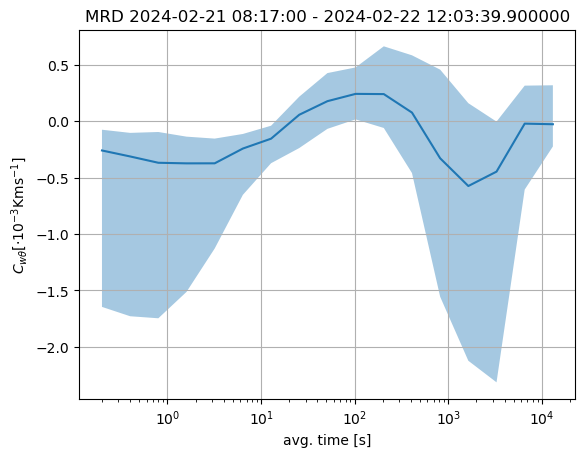

In [10]:
M=17
(mrd_x, mrd_data, time_middle)=completemrd(fastdata_rot[0:1000000], 'Uz', 'Ts', M, shift=round(int(0.1 * 2**M)), plot=True)

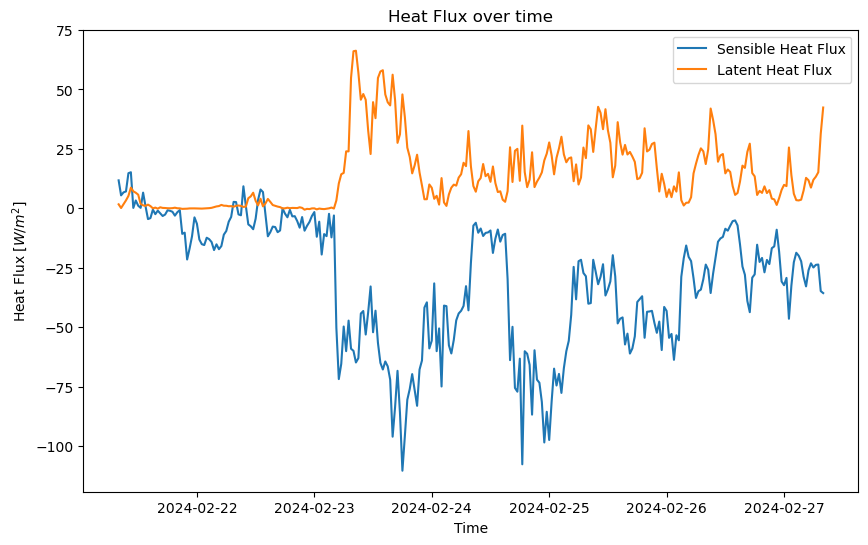

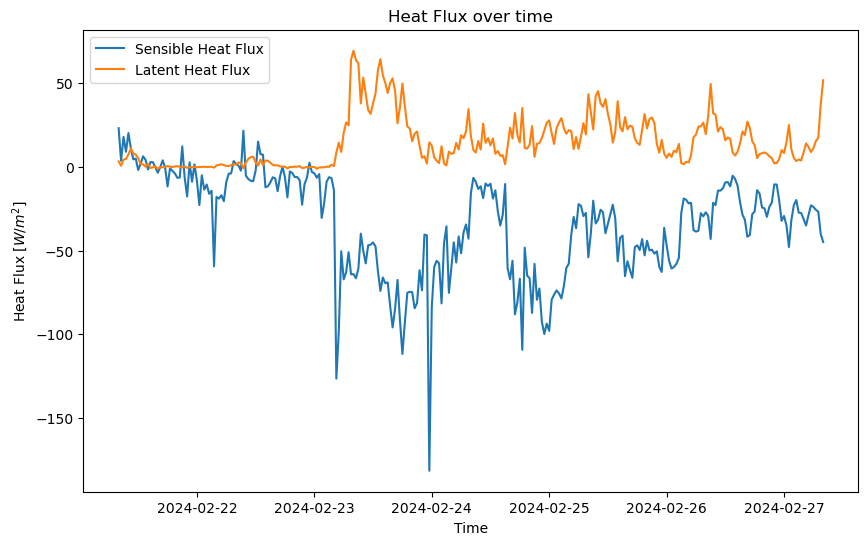

In [11]:
""" CHECK HEATFLUX QUICKLY WITH AVERAGING INTERVAL FOM MRD"""
df_heatflux=check_heat_flux(fastdata_rot, '20s', plot=True)
df_heatflux=check_heat_flux(fastdata_rot, '10min', plot=True)

In [26]:
fastdata_rot.to_csv(f'/home/engbers/Documents/PhD/Data/EC_despiked/{folder_name}/fast_{sensor}_{pd.Timestamp(start).strftime('%Y-%m-%d')}_{pd.Timestamp(end).strftime('%Y-%m-%d')}.csv')

/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_MRFD.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gaps = pd.concat([gaps, pd.DataFrame({'idx_before_gap': [len(data)],


MRD for DataFrame
Number of gaps: 1


 98%|█████████▊| 1696968/1728600 [04:31<00:05, 6256.52it/s]


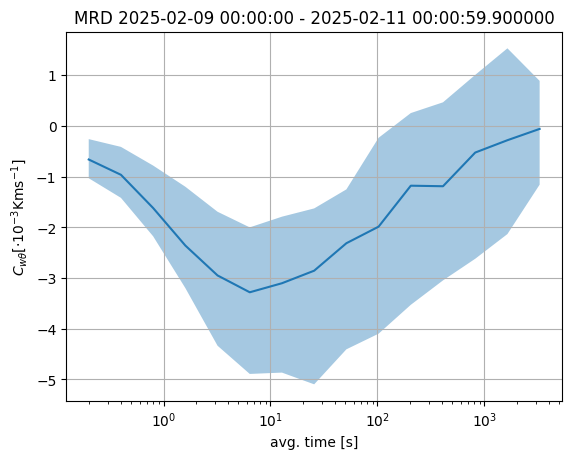

In [305]:
M=15
(mrd_x_1, mrd_data_1, time_middle_1)=completemrd(fastdata_rot, 'Uz', 'Ts', M, shift=round(int(0.1 * 2**M)), plot=True)


/tmp/ipykernel_1793656/983133572.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


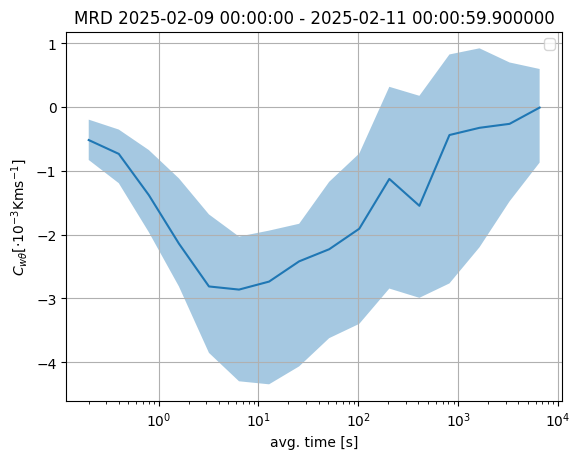

In [ ]:
fig, ax = plt.subplots()

# Set title dynamically using first and last time values from evaldf1
ax.set_title(f"MRD {fastdata_rot.index[0]} - {fastdata_rot.index[-1]}")
ax.set_xlabel("avg. time [s]")
ax.set_ylabel(r"$C_{w\theta} [\cdot 10^{-3} \mathrm{Kms^{-1}}]$")
ax.grid(True)

ax.set_xscale("log")

# Plot the median MRD values
ax.plot(np.array(seconds_array) ,(np.nanmedian(mrd_data_1, axis=1))*1000)

# Fill between the quantiles
ax.fill_between(np.array(seconds_array), 
                np.nanquantile(mrd_data_1, 0.25, axis=1) * 1000, 
                np.nanquantile(mrd_data_1, 0.75, axis=1) * 1000, 
                alpha=0.4)

ax.legend()
plt.show()
